<a href="https://colab.research.google.com/github/GiovanniPioDelvecchio/BigDataAnalyticsProject/blob/main/CreditCardClients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation of the required libraries

In [1]:
!pip3 install findspark
!pip3 install xlrd
!pip3 install scikit-learn
!pip3 install scikit-plot
!pip3 install kds

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# needed in colab, remove this cell when executing on VMs
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 12.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=a95f7b19bf2ac40c2e9380b54fe3ee3237a25905f364d5442d6a71be619f313d
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


In [3]:
import json

import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import kds
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler as skStandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%matplotlib inline

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType,\
                              StructField,\
                              IntegerType,\
                              DoubleType,\
                              StringType
from pyspark.ml.feature import StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier, \
                                      LogisticRegression, \
                                      DecisionTreeClassifier, \
                                      NaiveBayes
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType, FloatType
from pyspark.sql.functions import udf

print("the packages have been imported")

the packages have been imported


## Loading block and Analysis of the data
The following blocks are needed to load the dataset from the excel file,
create the current spark session, build the pyspark dataframe containing
the data and show its schema. Dataset analysis is also performed in order to observe the distributions of the data and find outliers

In [4]:
credit = pd.read_excel('./default of credit card clients.xls', header=1)


spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()

credit_schema = StructType([\
    StructField("ID", IntegerType(), False),
    StructField("LIMIT_BAL", IntegerType(), False),
    StructField("SEX", IntegerType(), False),
    StructField("EDUCATION", IntegerType(), False),
    StructField("MARRIAGE", IntegerType(), False),
    StructField("AGE", IntegerType(), False),
    StructField("PAY_0", IntegerType(), False),
    StructField("PAY_2", IntegerType(), False),
    StructField("PAY_3", IntegerType(), False),
    StructField("PAY_4", IntegerType(), False),
    StructField("PAY_5", IntegerType(), False),
    StructField("PAY_6", IntegerType(), False),
    StructField("BILL_AMT1", IntegerType(), False),
    StructField("BILL_AMT2", IntegerType(), False),
    StructField("BILL_AMT3", IntegerType(), False),
    StructField("BILL_AMT4", IntegerType(), False),
    StructField("BILL_AMT5", IntegerType(), False),
    StructField("BILL_AMT6", IntegerType(), False),
    StructField("PAY_AMT1", IntegerType(), False),
    StructField("PAY_AMT2", IntegerType(), False),
    StructField("PAY_AMT3", IntegerType(), False),
    StructField("PAY_AMT4", IntegerType(), False),
    StructField("PAY_AMT5", IntegerType(), False),
    StructField("PAY_AMT6", IntegerType(), False),
    StructField("default payment next month", IntegerType(), False)])

spark_credit= spark.createDataFrame(credit, schema = credit_schema)
spark_credit.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/usr/local/spark-3.3.1-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


root
 |-- ID: integer (nullable = false)
 |-- LIMIT_BAL: integer (nullable = false)
 |-- SEX: integer (nullable = false)
 |-- EDUCATION: integer (nullable = false)
 |-- MARRIAGE: integer (nullable = false)
 |-- AGE: integer (nullable = false)
 |-- PAY_0: integer (nullable = false)
 |-- PAY_2: integer (nullable = false)
 |-- PAY_3: integer (nullable = false)
 |-- PAY_4: integer (nullable = false)
 |-- PAY_5: integer (nullable = false)
 |-- PAY_6: integer (nullable = false)
 |-- BILL_AMT1: integer (nullable = false)
 |-- BILL_AMT2: integer (nullable = false)
 |-- BILL_AMT3: integer (nullable = false)
 |-- BILL_AMT4: integer (nullable = false)
 |-- BILL_AMT5: integer (nullable = false)
 |-- BILL_AMT6: integer (nullable = false)
 |-- PAY_AMT1: integer (nullable = false)
 |-- PAY_AMT2: integer (nullable = false)
 |-- PAY_AMT3: integer (nullable = false)
 |-- PAY_AMT4: integer (nullable = false)
 |-- PAY_AMT5: integer (nullable = false)
 |-- PAY_AMT6: integer (nullable = false)
 |-- default 

In [5]:
print(credit.dtypes)

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object


In [6]:
credit.head()
spark_credit.show()

23/03/01 16:49:04 WARN TaskSetManager: Stage 0 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.


+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

In [7]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [8]:
credit.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [9]:
credit = credit.drop('ID', axis = 1)
spark_credit = spark_credit.drop('ID')
spark_credit.show()

23/03/01 16:49:29 WARN TaskSetManager: Stage 1 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.


+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|     3455|     3261|  

In [10]:
credit.duplicated().sum()

35

In [11]:
credit = credit.drop_duplicates()
spark_credit = spark_credit.distinct()

Distribution plots, needed to check if data are normalized

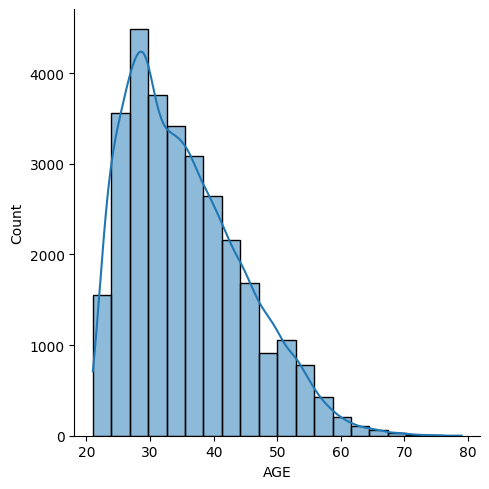

In [12]:
sns.displot(credit['AGE'], bins = 20, kde = True)

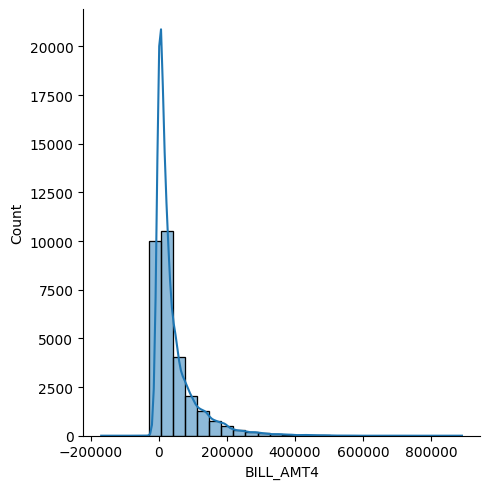

In [13]:
sns.displot(credit['BILL_AMT4'], bins = 30, kde = True)

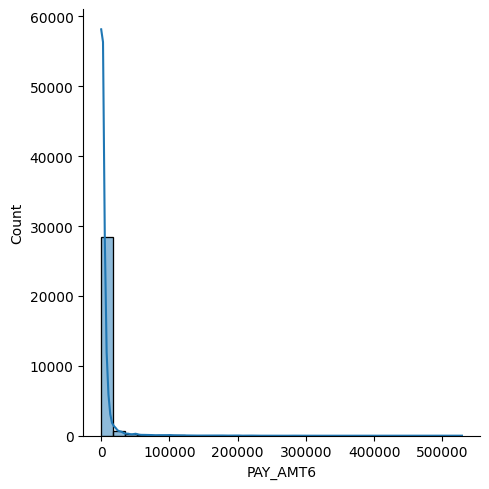

In [14]:
sns.displot(credit['PAY_AMT6'], bins = 30, kde = True)

<Axes: >

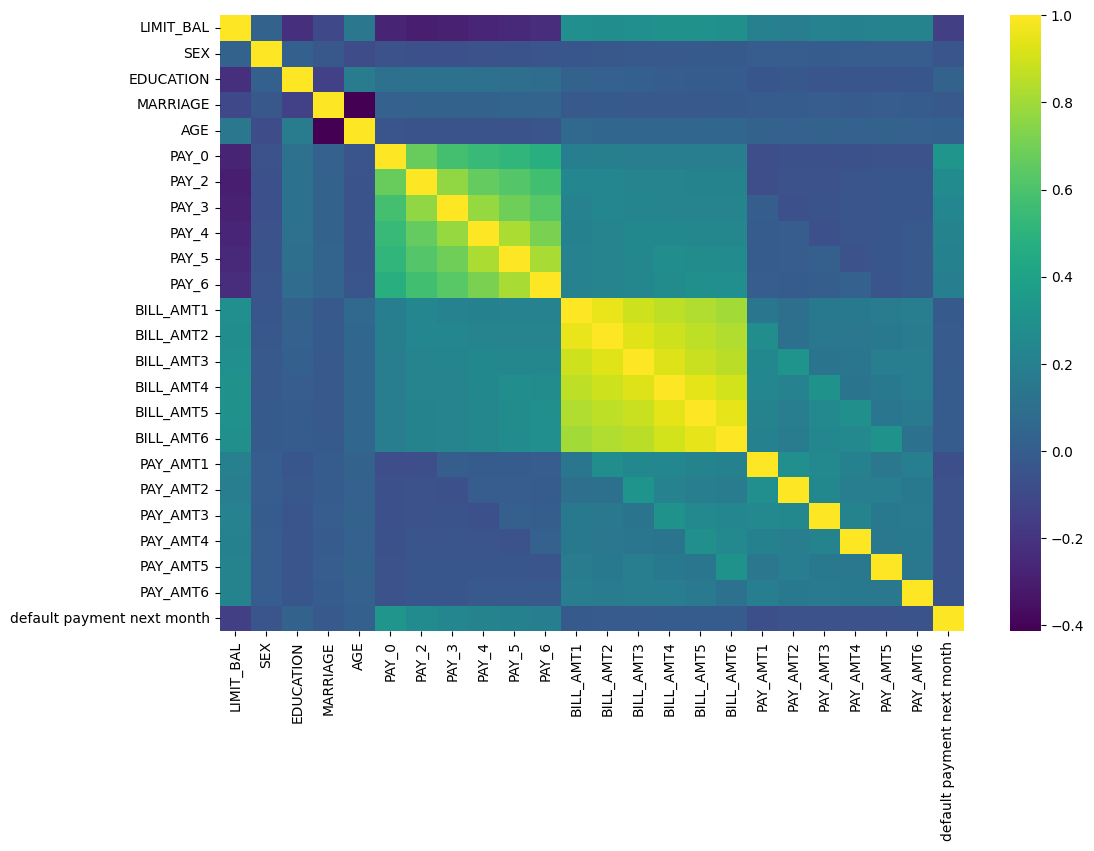

In [15]:
plt.figure(figsize = (12,8))
sns.heatmap(credit.corr(), cmap = 'viridis')

<Axes: xlabel='SEX', ylabel='count'>

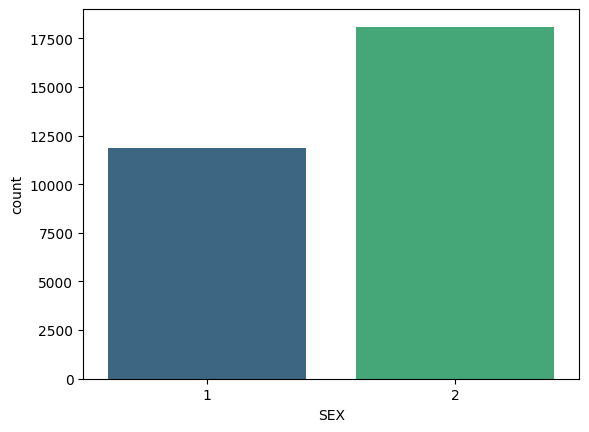

In [16]:
sns.countplot(x = 'SEX', data= credit, palette = 'viridis')

In [17]:
credit['SEX'].value_counts()

2    18091
1    11874
Name: SEX, dtype: int64

<Axes: xlabel='SEX', ylabel='count'>

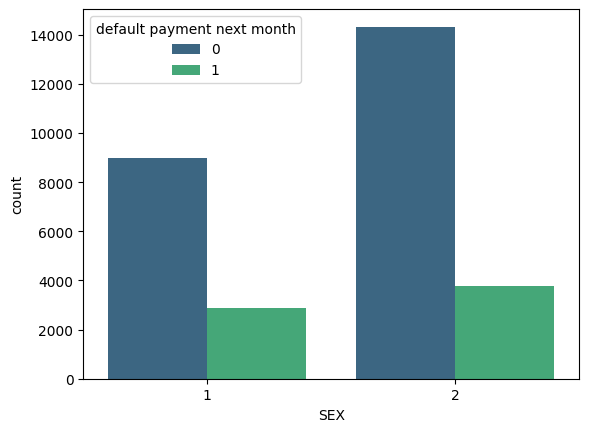

In [18]:
sns.countplot(x = 'SEX', data = credit, palette = 'viridis', hue = 'default payment next month')

In [19]:
credit['EDUCATION'].value_counts()

2    14019
1    10563
3     4915
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

<Axes: xlabel='EDUCATION', ylabel='count'>

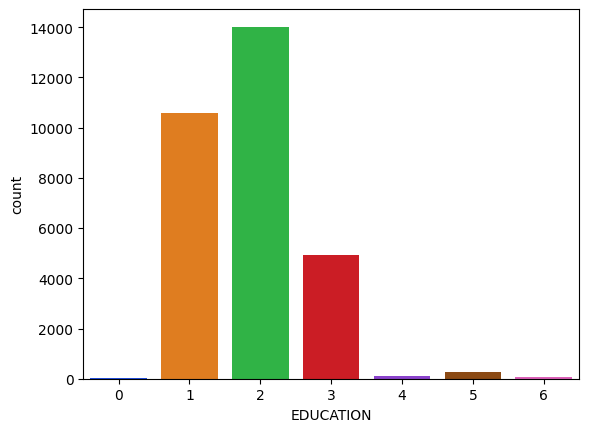

In [20]:
sns.countplot(x ='EDUCATION', data = credit, palette = 'bright')

<Axes: xlabel='EDUCATION', ylabel='count'>

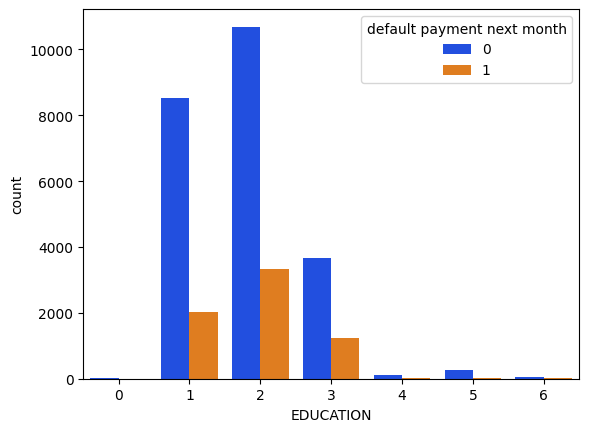

In [21]:
sns.countplot(x = 'EDUCATION', data = credit, palette = 'bright', hue = 'default payment next month')

In [22]:
credit['MARRIAGE'].value_counts()

2    15945
1    13643
3      323
0       54
Name: MARRIAGE, dtype: int64

<Axes: xlabel='MARRIAGE', ylabel='count'>

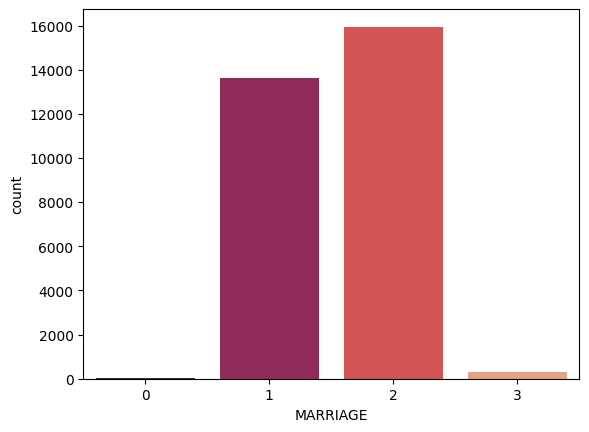

In [23]:
sns.countplot(x = 'MARRIAGE', data = credit, palette = 'rocket')

<Axes: xlabel='MARRIAGE', ylabel='count'>

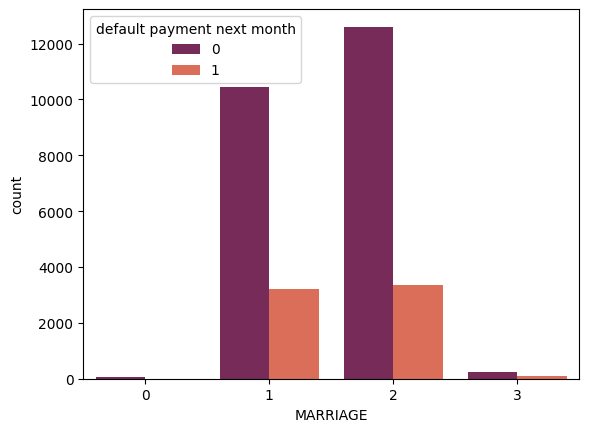

In [24]:
sns.countplot(x = 'MARRIAGE', data = credit, palette = 'rocket', hue = 'default payment next month')

<Axes: xlabel='LIMIT_BAL'>

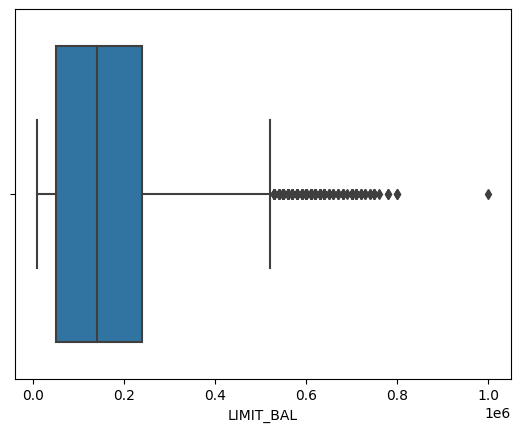

In [25]:
sns.boxplot(x = 'LIMIT_BAL', data = credit)

<Axes: xlabel='PAY_AMT6'>

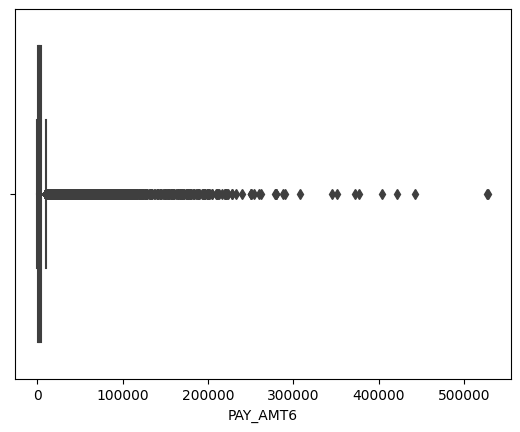

In [26]:
sns.boxplot(x = 'PAY_AMT6', data = credit)

Elimination of the outliers in the figure above

In [27]:
credit = credit[(credit['LIMIT_BAL'] <= 550000) & (credit['PAY_AMT6'] <= 50000)]
spark_credit = spark_credit.where(col('LIMIT_BAL') <= 550000 ).where(col('PAY_AMT6') <= 50000)

In [28]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29327 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   29327 non-null  int64
 1   SEX                         29327 non-null  int64
 2   EDUCATION                   29327 non-null  int64
 3   MARRIAGE                    29327 non-null  int64
 4   AGE                         29327 non-null  int64
 5   PAY_0                       29327 non-null  int64
 6   PAY_2                       29327 non-null  int64
 7   PAY_3                       29327 non-null  int64
 8   PAY_4                       29327 non-null  int64
 9   PAY_5                       29327 non-null  int64
 10  PAY_6                       29327 non-null  int64
 11  BILL_AMT1                   29327 non-null  int64
 12  BILL_AMT2                   29327 non-null  int64
 13  BILL_AMT3                   29327 non-null  int64
 14  BILL_A

In [29]:
print(spark_credit.dtypes)
spark_credit.summary().show()

[('LIMIT_BAL', 'int'), ('SEX', 'int'), ('EDUCATION', 'int'), ('MARRIAGE', 'int'), ('AGE', 'int'), ('PAY_0', 'int'), ('PAY_2', 'int'), ('PAY_3', 'int'), ('PAY_4', 'int'), ('PAY_5', 'int'), ('PAY_6', 'int'), ('BILL_AMT1', 'int'), ('BILL_AMT2', 'int'), ('BILL_AMT3', 'int'), ('BILL_AMT4', 'int'), ('BILL_AMT5', 'int'), ('BILL_AMT6', 'int'), ('PAY_AMT1', 'int'), ('PAY_AMT2', 'int'), ('PAY_AMT3', 'int'), ('PAY_AMT4', 'int'), ('PAY_AMT5', 'int'), ('PAY_AMT6', 'int'), ('default payment next month', 'int')]
23/03/01 16:51:06 WARN TaskSetManager: Stage 2 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.


+-------+------------------+-------------------+------------------+------------------+-----------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+--------------------------+
|summary|         LIMIT_BAL|                SEX|         EDUCATION|          MARRIAGE|              AGE|               PAY_0|              PAY_2|              PAY_3|              PAY_4|              PAY_5|               PAY_6|        BILL_AMT1|        BILL_AMT2|        BILL_AMT3|        BILL_AMT4|         BILL_AMT5|         BILL_AMT6|          PAY_AMT1|         PAY_AMT2|          PAY_AMT3|         PAY_AMT4|          PAY_AMT5|          PAY_AMT6|default payment next month|
+-------+------------------+-------------------+

<Axes: xlabel='LIMIT_BAL'>

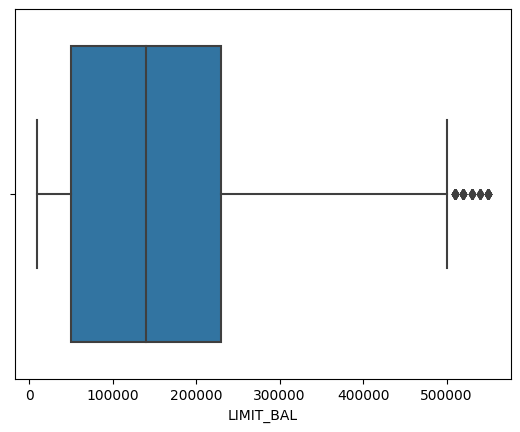

In [31]:
sns.boxplot(x = 'LIMIT_BAL', data = credit)

<Axes: xlabel='PAY_AMT6'>

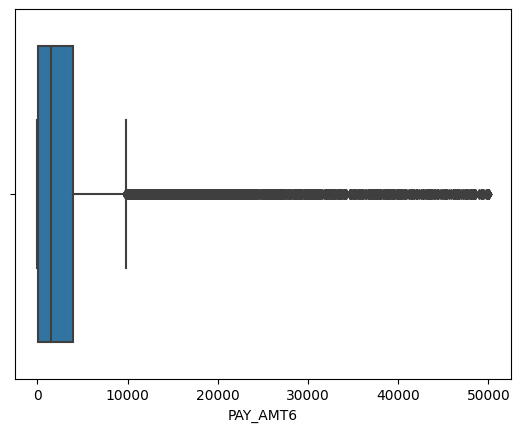

In [32]:
sns.boxplot(x = 'PAY_AMT6', data = credit)

In [33]:
scaler = skStandardScaler()
scaler.fit(credit.drop('default payment next month', axis = 1))

StandardScaler()

In [34]:
scaled_data = scaler.transform(credit.drop('default payment next month', axis = 1))

In [35]:
credit_feat = pd.DataFrame(scaled_data, columns = credit.columns[:-1])
credit_feat.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.145938,0.808931,0.181643,-1.056759,-1.241323,1.789316,1.773333,-0.701946,-0.670775,-1.531718,...,-0.674654,-0.680832,-0.671624,-0.663706,-0.364728,-0.231728,-0.325459,-0.318327,-0.315232,-0.570660
1,-0.345691,0.808931,0.181643,0.857601,-1.024683,-0.881770,1.773333,0.131865,0.182037,0.228359,...,-0.644949,-0.628190,-0.612902,-0.607288,-0.364728,-0.216941,-0.258931,-0.248680,-0.315232,-0.224495
2,-0.585765,0.808931,0.181643,0.857601,-0.158120,0.008592,0.105013,0.131865,0.182037,0.228359,...,-0.482834,-0.450267,-0.417562,-0.394695,-0.260885,-0.193169,-0.258931,-0.248680,-0.245605,0.294753
3,-0.905864,0.808931,0.181643,-1.056759,0.166841,0.008592,0.105013,0.131865,0.182037,0.228359,...,0.049729,-0.225300,-0.179425,-0.152519,-0.227912,-0.168493,-0.245626,-0.241715,-0.240800,-0.397577
4,-0.905864,-1.236200,0.181643,-1.056759,2.333247,-0.881770,0.105013,-0.701946,0.182037,0.228359,...,-0.150824,-0.343937,-0.346211,-0.332724,-0.227912,1.479504,0.339819,0.308495,-0.267259,-0.453137


In [36]:
train_cred, test_cred = spark_credit.randomSplit([0.49, 0.51], seed = 10)
train_cred.show()
test_cred.show()

23/03/01 16:52:04 WARN TaskSetManager: Stage 8 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.


+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|    10000|  1|        1|       1| 38|   -1|   -1|    2|    0|    0|    2|     4711|     9617|     9307|     9665|    10470|    10169|    5000|       0|     500|    1100|       0|    1000|                         1|
|    10000|  1|        1|       1| 48|    1|    2|    0|    0|    0|    0|     8594|     7421|     8145|     9000|     9000|        0|  

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|    10000|  1|        1|       1| 40|    2|   -1|   -1|   -2|   -2|   -2|     3567|     1000|        0|        0|        0|        0|    5000|       0|       0|       0|       0|       0|                         1|
|    10000|  1|        1|       1| 41|    0|    0|    3|    2|    2|    2|     6859|     9751|     9451|     9169|    10056|     8559|  

In [37]:
def serialize_df(df_to_ser, path_where_ser, df_name):
  """
  Function to serialize a pyspark dataframe to json while also saving its schema.

  Params:
    df_to_ser: dataframe to serialize
    path_where_ser: root directory where the files (one json file for the schema
                    and another one for data) will be saved
    df_name: the name of the dataset that must be serialized (it is a string
             that will be added to both json files)
  """
  schema_to_ser = df_to_ser.schema.json()  
  with open(path_where_ser + "%s_schema.json"%df_name, "w") as json_file:
    to_ser = json.dumps(schema_to_ser, indent = 4)
    json_file.write(to_ser)
  df_to_ser.write.json(path_where_ser + "/%s.json"%df_name, mode="overwrite")


def load_df(path_where_ser, df_name):
  """
  Function to load a pyspark dataframe known its schema.

  Params: 
    path_where_ser: root directory of the files of the 
                    serialized dataset and its schema
    df_name: actual name of the df (string that was used to give a name the
             json file)
  Returns:
    to_return: the loaded dataset with the loaded schema
  """
  with open(path_where_ser + "%s_schema.json"%df_name, "r") as json_file:
    json_obj = json.load(json_file)
    loaded_schema = StructType.fromJson(json.loads(json_obj))
  to_return = spark.read.format("json") \
                        .option("header", "true") \
                        .schema(loaded_schema) \
                        .load(path_where_ser + "/%s.json"%df_name)
  return to_return

In [41]:
col_list = [spark_credit.dtypes[i][0] for i in range(0, len(spark_credit.dtypes)-1)]
credit_vec_ass = VectorAssembler(inputCols = col_list, outputCol = "temp_features")

credit_assembled = credit_vec_ass.transform(spark_credit)
train_assembled = credit_vec_ass.transform(train_cred)
test_assembled = credit_vec_ass.transform(test_cred)

# in "Scaled" there will be values scaled with the corrected sample standard deviation,
# instead of the population-based standard deviation
spark_scaler = StandardScaler(withMean=True, withStd=True, inputCol="temp_features", outputCol="scaled")
fitted_scaler = spark_scaler.fit(dataset = credit_assembled)
scaled_data = fitted_scaler.transform(credit_assembled)
scaled_train = fitted_scaler.transform(train_assembled)
scaled_test = fitted_scaler.transform(test_assembled)

vectorized_scaled_data = scaled_data.select(["scaled", "default payment next month"])
vectorized_scaled_train = scaled_train.select(["scaled", "default payment next month"])
vectorized_scaled_test = scaled_test.select(["scaled", "default payment next month"])
vectorized_scaled_data.show()
vectorized_scaled_train.show()
vectorized_scaled_test.show()

serialize_df(vectorized_scaled_train, "./serialized/", "vectorized_scaled_train")
serialize_df(vectorized_scaled_test, "./serialized/", "vectorized_scaled_test")

23/03/01 16:55:12 WARN TaskSetManager: Stage 29 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.


23/03/01 16:55:15 WARN TaskSetManager: Stage 35 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------------+
|              scaled|default payment next month|
+--------------------+--------------------------+
|[0.61459469682298...|                         0|
|[0.53457136090135...|                         0|
|[0.53457136090135...|                         0|
|[-0.9058486856880...|                         0|
|[0.45454802497971...|                         0|
|[-0.5857553420015...|                         0|
|[1.57487472788257...|                         0|
|[-0.5857553420015...|                         0|
|[-0.7458020138447...|                         0|
|[-0.1856386623933...|                         1|
|[-0.1056153264717...|                         1|
|[-0.1056153264717...|                         0|
|[1.09473471235277...|                         0|
|[-1.1459186934529...|                         0|
|[-0.9058486856880...|                         1|
|[0.85466470458788...|                         0|
|[0.05443134537155...|                         0|


+--------------------+--------------------------+
|              scaled|default payment next month|
+--------------------+--------------------------+
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         1|


+--------------------+--------------------------+
|              scaled|default payment next month|
+--------------------+--------------------------+
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         0|
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         1|
|[-1.2259420293745...|                         0|


23/03/01 16:55:26 WARN TaskSetManager: Stage 47 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.


In [42]:
vectorized_scaled_train = load_df("./serialized/", "vectorized_scaled_train")
vectorized_scaled_test = load_df("./serialized/", "vectorized_scaled_test")

## Construction and fitting of the Multilayer Perceptron classifier from spark.ml.classification
preliminarly to the construction of the classifier a further preprocessing step must be performed: the distribution of each feature must be in range \[0,1\]. <br>

In [43]:
min_max_scaler = MinMaxScaler(min=0.0, max=1.0, inputCol='scaled', outputCol="min_maxed_scaled")
fitted_min_max_scaler = min_max_scaler.fit(vectorized_scaled_data)
mm_scaled_train = fitted_min_max_scaler.transform(vectorized_scaled_train).select("min_maxed_scaled", "default payment next month")
mm_scaled_test = fitted_min_max_scaler.transform(vectorized_scaled_test).select("min_maxed_scaled", "default payment next month")

23/03/01 16:55:57 WARN TaskSetManager: Stage 50 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.


In [44]:
serialize_df(mm_scaled_train, "./serialized/", "mm_scaled_train")
serialize_df(mm_scaled_test, "./serialized/", "mm_scaled_test")

In [45]:
mm_scaled_train = load_df("./serialized/", "mm_scaled_train")
mm_scaled_test = load_df("./serialized/", "mm_scaled_test")

In [46]:
mlpc=MultilayerPerceptronClassifier(featuresCol="min_maxed_scaled", 
                                    labelCol="default payment next month",
                                    layers = [23, 10, 5, 2],
                                    maxIter=100,
                                    blockSize=30,
                                    seed=10)

In [47]:
mlpc_fitted = mlpc.fit(mm_scaled_train)
print(mlpc.explainParams())
mlpc.write().overwrite().save("./serialized/mlpc-model")

23/03/01 16:57:01 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/01 16:57:01 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


23/03/01 16:58:45 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/01 16:58:45 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


blockSize: block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data. (default: 128, current: 30)
featuresCol: features column name. (default: features, current: min_maxed_scaled)
initialWeights: The initial weights of the model. (undefined)
labelCol: label column name. (default: label, current: default payment next month)
layers: Sizes of layers from input layer to output layer E.g., Array(780, 100, 10) means 780 inputs, one hidden layer with 100 neurons and output layer of 10 neurons. (current: [23, 10, 5, 2])
maxIter: max number of iterations (>= 0). (default: 100, current: 100)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. 

In [48]:
mlpc.load("./serialized/mlpc-model")

MultilayerPerceptronClassifier_771b515f11b1

## Construction and fitting of the Logistic Regression classifier from spark.ml.classification

In [49]:
blor = LogisticRegression(featuresCol="scaled", labelCol="default payment next month", regParam = 0.01, maxIter = 10)

In [53]:
blorModel = blor.fit(vectorized_scaled_train)
blorModel.write().overwrite().save("./serialized/blorModel")

In [51]:
blorModel.load("./serialized/blorModel")

LogisticRegressionModel: uid=LogisticRegression_9f30e41c78b0, numClasses=2, numFeatures=23

## Construction and fitting of the Decision Tree classifier from spark.ml.classification

In [54]:
dec_tree = DecisionTreeClassifier(featuresCol="scaled", labelCol="default payment next month")

In [55]:
dec_tree_model = dec_tree.fit(vectorized_scaled_train)
dec_tree_model.write().overwrite().save("./serialized/decTreeModel")

In [56]:
dec_tree_model.load("./serialized/decTreeModel")

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_1eaf7823ff79, depth=5, numNodes=31, numClasses=2, numFeatures=23

## Construction and fitting of the Naive Bayes classifier from spark.ml.classification
preliminarly to the construction of the classifier a further preprocessing step must be performed: the data must be positive. <br>
Since the features are already standardized, they can be made positive by subtracting the lowest negative value of each feature to all the elements of the corresponding feature.

In [57]:
def split_array_to_list(col):
  """
  Function to unpack the results of a VectorAssembler.

  Params:
    col: the pyspark column that must be unpacked, it contains vectors
  Returns:
    the application of the function to the column passed as parameter,
    transforming it into an array (from vector)
  """
  def to_list(v):
      return v.toArray().tolist()
  return F.udf(to_list, ArrayType(DoubleType()))(col)

def getMinArray(vectorized_scaled_data):
  """
  Function to get an array containing the minimum value for each feature.

  Params:
    vectorized_scaled_data: a pyspark dataframe obtained as the result of
                            VectorAssembler, where the features are placed
                            in the column "scaled"
  Returns:
    min_array: an array that contains the minimum value for each feature of
               vectorized_scaled_data
  """
  unpacked_data = vectorized_scaled_data.select(split_array_to_list(F.col("scaled")).alias("splitted")).select([F.col("splitted")[i].alias(str(col_list[i])) for i in range(len(col_list))])
  min_row = unpacked_data.select([F.min(str(col_list[i])).alias(str(col_list[i])) for i in range(len(col_list))])
  min_row = credit_vec_ass.transform(min_row).select(F.col("temp_features").alias("scaled"))
  min_array = min_row.first().asDict().get("scaled")
  return min_array.toArray()

min_arr = getMinArray(vectorized_scaled_data)
print(type(min_arr))
print(min_arr)

23/03/01 19:45:28 WARN TaskSetManager: Stage 239 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.


<class 'numpy.ndarray'>
[-1.22594203 -1.23617861 -2.35741833 -2.97106933 -1.56625736 -1.77210187
 -1.5632804  -1.53573041 -1.52356071 -1.53169156 -1.48841692 -3.03817327
 -1.71208641 -3.02879341 -3.41582794 -2.05397784 -2.30075491 -0.36472188
 -0.26448145 -0.32545343 -0.31832158 -0.31522648 -0.57065046]


In [59]:
def remove_negative_values(vectorized_scaled, min_array):
  """
  Function that removes negative values by subtracting to each element of each feature
  the minimum value for that feature (if it is negative).

  Params:
    vectorized_scaled: a pyspark dataframe obtained as the result of
                        VectorAssembler, where the features are placed
                        in the column "scaled"
    min_array: an array containing the minimum values for each feature
               of vectorized_scaled
  Returns:
    vec_unpacked_data: an assembled pyspark dataframe where the column "temp_features"
                       contains vectors where each feature is positive
  """
  unpacked_data = vectorized_scaled.select(split_array_to_list(F.col("scaled")).alias("splitted"), F.col("default payment next month"))\
  .select([F.col("splitted")[i].alias(str(col_list[i])) if i < len(col_list) else F.col("default payment next month") for i in range(len(col_list)+1)])
  for i in range(len(col_list)):
    if min_array[i] < 0:
      unpacked_data = unpacked_data.withColumn(str(col_list[i]) + "_positive", F.col(str(col_list[i])) - min_array[i])
      unpacked_data = unpacked_data.drop(str(col_list[i]))

  unpacked_col_list = [unpacked_data.dtypes[i][0] for i in range(0, len(unpacked_data.dtypes) - 1)]
  vec_ass = VectorAssembler(inputCols = unpacked_col_list, outputCol = "temp_features")
  vec_unpacked_data = vec_ass.transform(unpacked_data).select("temp_features", "default payment next month")
  return vec_unpacked_data

vectorized_positive_train = remove_negative_values(vectorized_scaled_train, min_arr)
vectorized_positive_test = remove_negative_values(vectorized_scaled_test, min_arr)

In [60]:
serialize_df(vectorized_positive_train, "./serialized/", 
             "vectorized_positive_train")
serialize_df(vectorized_positive_test, "./serialized/", 
             "vectorized_positive_test")

In [61]:
vectorized_positive_train = load_df("./serialized/", "vectorized_positive_train")
vectorized_positive_test = load_df("./serialized/", "vectorized_positive_test")

In [62]:
naive_b = NaiveBayes(smoothing=1.0, modelType="multinomial", 
                     featuresCol="temp_features", 
                     labelCol="default payment next month")

In [63]:
model_naive_b = naive_b.fit(vectorized_positive_train) 
model_naive_b.write().overwrite().save("./serialized/naiveBayesModel")

In [64]:
model_naive_b.load("./serialized/naiveBayesModel")

NaiveBayesModel: uid=NaiveBayes_b71b601dd642, modelType=multinomial, numClasses=2, numFeatures=23

## Construction and fitting of an Approximated KNN classifier

In [65]:
def dist_knn_mapping(vector, lil_dataframe, labels, k_val):
  """
  Function needed to compute the distance between a fixed amount of 
  examples in lil_dataframe and the current example of a Spark DataFrame.
  This function will be converted to a Spark udf.

  Params:
    vector: the vector for which we need to compute the distance 
            with every example of lil_dataframe
    lil_dataframe: a batch of examples of which we want to know which
                   are the k_val nearest neighbors with respect to vector
    labels: the label values associated to each example of lil_dataframe
    k_val: the number of nearest neighbors of vector, which must be
           elements of lil_dataframe
  Returns:
    to_return: the sum of the labels associated to the k_val nearest neighbors 
               of vector in lil_dataframe, divided by k_val (in must be used
               as a probability value, thus if 3 neighbors out of 5 are labeled
               as 1 and the others as 0, we have a probability 
               value of 3/5 = 0.6)
  """
  ex_arr = vector.toArray()
  val_list = []
  for elem in lil_dataframe:
    to_sub = np.array(elem)
    val = np.linalg.norm(ex_arr - to_sub)
    val_list.append(val)
  nearest_indices = np.argsort(val_list)[:k_val]
  acc = 0
  for elem in nearest_indices:
    acc += labels[elem]
  to_return = acc / k_val
  return float(to_return)

train_true = vectorized_scaled_train.where(col("default payment next month") == 1)
train_false = vectorized_scaled_train.where(col("default payment next month") == 0)
tot_true = train_true.count()
tot_false = train_false.count()
perc_true = ((1 / tot_true) * 200) 
perc_false = ((1 / tot_false) * 190)

sampled_true = train_true.sample(False, perc_true, seed = 1234)
sampled_false = train_false.sample(False, perc_false, seed = 1234)

true_arr = sampled_true.toPandas()
false_arr = sampled_false.toPandas()
knn_examples = pd.concat([true_arr, false_arr], axis = 0)


examples = [elem.toArray() for elem in knn_examples["scaled"]]
labels = [int(elem) for elem in knn_examples["default payment next month"]]
knn_udf = udf(lambda x: dist_knn_mapping(x, examples, labels, 5), FloatType())
Y_probs = vectorized_scaled_test.withColumn("probs", knn_udf(vectorized_scaled_test["scaled"])).select("probs").collect()

## Construction and fitting of a Linear Discriminant Analysis classifier from multiple distributed files

In [67]:
def split_and_save(train_cred, path, n_partitions):
    pd_train = train_cred.select("*").toPandas()
    splits = []
    length_each_split = pd_train.shape[0] // n_partitions
    for i in range(0, n_partitions): 
      if i == n_partitions - 1:
        i_range = np.arange(i*length_each_split, pd_train.shape[0])
        print(i_range)
      else:
        i_range = np.arange(i*length_each_split, length_each_split+(i*length_each_split))
        print(i_range)

      to_save = pd_train.iloc[i_range]
      print(to_save.shape)
      to_save.to_json(path+"train_split_%s.json" %i)

p_where_save = "./train_partitions/" # change this with hdfs path
split_and_save(train_cred, p_where_save, 3)

23/03/01 20:04:26 WARN TaskSetManager: Stage 269 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.
[   0    1    2 ... 4773 4774 4775]
(4776, 24)
[4776 4777 4778 ... 9549 9550 9551]
(4776, 24)
[ 9552  9553  9554 ... 14325 14326 14327]
(4776, 24)


In [68]:
def load_splitted(path, n_partitions):
  to_conc = []
  for i in range(0, n_partitions):
    df_curr_part = pd.read_json(path+"train_split_%s.json"%i).values
    print(df_curr_part.shape)
    to_conc.append(df_curr_part)
  to_return = np.concatenate(to_conc, axis = 0)
  return to_return

np_data = load_splitted(p_where_save, 3)
print(np_data.shape)
print(np_data[:3, :])

(4776, 24)
(4776, 24)
(4776, 24)
(14328, 24)
[[10000     1     1     1    38    -1    -1     2     0     0     2  4711
   9617  9307  9665 10470 10169  5000     0   500  1100     0  1000     1]
 [10000     1     1     1    48     1     2     0     0     0     0  8594
   7421  8145  9000  9000     0     0  2000  2000     0     0     0     0]
 [10000     1     1     1    50     0     0     0     0     0     0 10043
   9616  9718  9916  9250  7461  1194  1076   274   370   472   375     0]]


In [69]:
lda = LinearDiscriminantAnalysis(solver = "svd", tol=0.0001)
data_X = np_data[:, :np_data.shape[1]]
data_y = np_data[:, np_data.shape[1] - 1]
fitted_lda = lda.fit(data_X, data_y)

## Evaluation of the classifiers
The cells below are needed to compute the performances of the classifiers that have been fitted, in this case the "collect()" is a valid operation since it is performed on the test set only.

In [70]:
def plot_cumulative_gains_both_classes(y_true, y_probs):
  """
  Function to plot the cumulative gains chart.
  It plots the cumulative number of positive predictions made,
  as function of the total number of positive preditcions

  Params:
    y_true: an array of length num_examples containing the ground truth labels
    y_probs: the probabilities associated for each example
             to each label, it is an array of shape (num_examples, num_classes)  
  """
  skplt.metrics.plot_cumulative_gain(y_true, y_probs)
  plt.xlabel("Number of observations")
  plt.ylabel("Cumulative number of true positive predictions")
  plt.title("Cumulative Gains Chart")
  plt.show()

In [71]:
# extraction of probabilities and predicted labels for the mlpc classifier
Y_true_mlpc = mm_scaled_test.select("default payment next month").collect()

test_cred_no_def = mm_scaled_test.select("min_maxed_scaled")
Y_pred_df_mlpc = mlpc_fitted.transform(test_cred_no_def)
Y_pred_probabilities_mlpc = Y_pred_df_mlpc.select("probability").collect()
Y_pred_predictions_mlpc = Y_pred_df_mlpc.select("prediction").collect()

Y_pred_probs_np_mlpc = np.array(Y_pred_probabilities_mlpc)
Y_pred_probs_np_mlpc = np.reshape(Y_pred_probs_np_mlpc, (Y_pred_probs_np_mlpc.shape[0], 2))

In [72]:
# extraction of probabilities and predicted labels for the logistic regression
# classifier
test_cred_no_def = vectorized_scaled_test.select("scaled")
Y_true_logreg = vectorized_scaled_test.select("default payment next month").collect()
Y_pred_df_logreg = blorModel.transform(test_cred_no_def)
Y_pred_probabilities_logreg = Y_pred_df_logreg.select("probability").collect()
Y_pred_predictions_logreg = Y_pred_df_logreg.select("prediction").collect()

Y_pred_probs_np_logreg = np.array(Y_pred_probabilities_logreg)
Y_pred_probs_np_logreg = np.reshape(Y_pred_probs_np_logreg, (Y_pred_probs_np_logreg.shape[0], 2))

In [73]:
# extraction of probabilities and predicted labels for the decision tree
# classifier
Y_true_dect = Y_true_logreg
Y_pred_df_dect = dec_tree_model.transform(test_cred_no_def)
Y_pred_probabilities_dect = Y_pred_df_dect.select("probability").collect()
Y_pred_predictions_dect = Y_pred_df_dect.select("prediction").collect()

Y_pred_probs_np_dect = np.array(Y_pred_probabilities_dect)
Y_pred_probs_np_dect = np.reshape(Y_pred_probs_np_dect, (Y_pred_probs_np_dect.shape[0], 2))

In [74]:
# extraction of probabilities and predicted labels for the naive Bayes 
# classifier
Y_true_nb = vectorized_positive_test.select("default payment next month").collect()
test_cred_no_def = vectorized_positive_test.select("temp_features")
Y_pred_df_nb = model_naive_b.transform(test_cred_no_def)
Y_pred_probabilities_nb = Y_pred_df_nb.select("probability").collect()
Y_pred_predictions_nb = Y_pred_df_nb.select("prediction").collect()

Y_pred_probs_np_nb = np.array(Y_pred_probabilities_nb)
Y_pred_probs_np_nb = np.reshape(Y_pred_probs_np_nb, (Y_pred_probs_np_nb.shape[0], 2))

In [75]:
# extraction of probabilities and predicted labels for the approximate knn
# classifier
Y_pred_probs_np_knn = np.zeros((len(Y_probs), 2))
Y_pred_probs_np_knn[:, 1] = np.reshape(np.array(Y_probs), len(Y_probs))
Y_pred_probs_np_knn[:, 0] = 1 - Y_pred_probs_np_knn[:, 1]
Y_true_knn = vectorized_scaled_test.select("default payment next month").collect()
Y_pred_predictions_knn = np.array([1 if elem > 0.5 else 0 for elem in Y_pred_probs_np_knn[:, 1]])

In [76]:
# extraction of probabilities and predicted labels for the LDA classifier
test_data = test_cred.toPandas().values
data_X = test_data[:, :test_data.shape[1]]
Y_true_lda = test_data[:, test_data.shape[1] - 1]
Y_pred_predictions_lda = fitted_lda.predict(data_X)
Y_pred_probs_np_lda = fitted_lda.predict_proba(data_X)

23/03/01 20:06:05 WARN TaskSetManager: Stage 284 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.


              precision    recall  f1-score   support

           0       0.84      0.95      0.89     11594
           1       0.69      0.38      0.49      3405

    accuracy                           0.82     14999
   macro avg       0.76      0.66      0.69     14999
weighted avg       0.81      0.82      0.80     14999



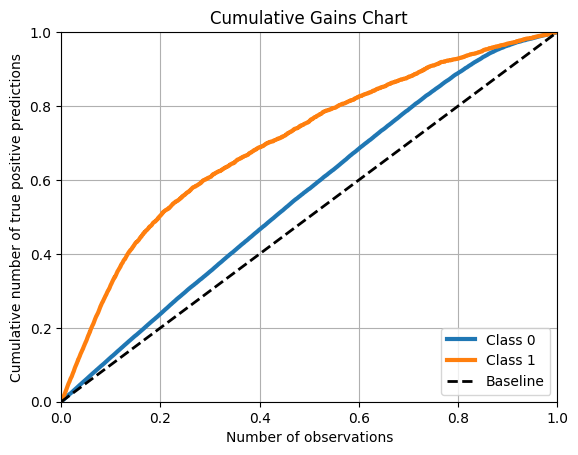

In [78]:
print(classification_report(Y_true_mlpc, Y_pred_predictions_mlpc))
plot_cumulative_gains_both_classes(Y_true_mlpc, Y_pred_probs_np_mlpc)

              precision    recall  f1-score   support

           0       0.81      0.97      0.88     11594
           1       0.71      0.21      0.33      3405

    accuracy                           0.80     14999
   macro avg       0.76      0.59      0.61     14999
weighted avg       0.79      0.80      0.76     14999



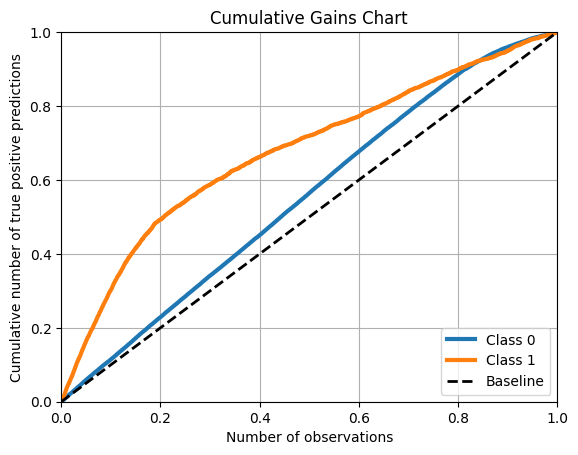

In [79]:
print(classification_report(Y_true_logreg, Y_pred_predictions_logreg))
plot_cumulative_gains_both_classes(np.array(Y_true_logreg), Y_pred_probs_np_logreg)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     11594
           1       0.71      0.34      0.46      3405

    accuracy                           0.82     14999
   macro avg       0.77      0.65      0.68     14999
weighted avg       0.80      0.82      0.79     14999



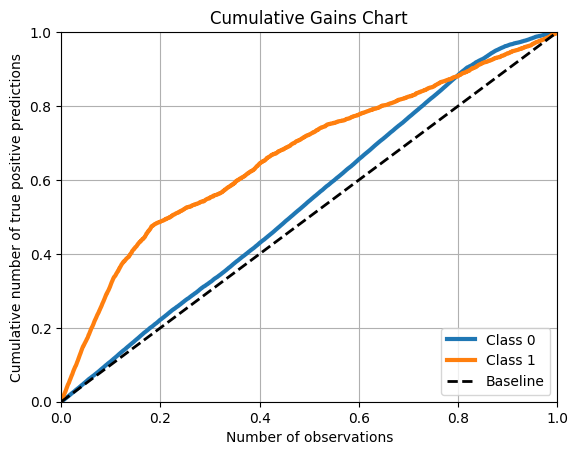

In [80]:
print(classification_report(Y_true_dect, Y_pred_predictions_dect))
plot_cumulative_gains_both_classes(np.array(Y_true_dect), Y_pred_probs_np_dect)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     11594
           1       0.89      0.99      0.94      3405

    accuracy                           0.97     14999
   macro avg       0.94      0.98      0.96     14999
weighted avg       0.97      0.97      0.97     14999



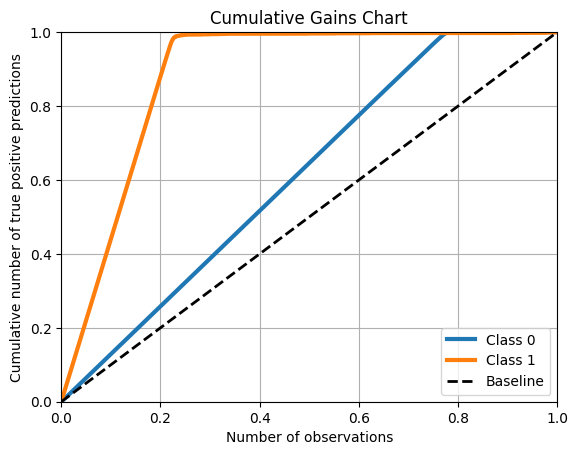

In [81]:
print(classification_report(Y_true_nb, Y_pred_predictions_nb))
plot_cumulative_gains_both_classes(np.array(Y_true_nb), Y_pred_probs_np_nb)

              precision    recall  f1-score   support

           0       0.85      0.71      0.77     11594
           1       0.36      0.57      0.44      3405

    accuracy                           0.68     14999
   macro avg       0.61      0.64      0.61     14999
weighted avg       0.74      0.68      0.70     14999



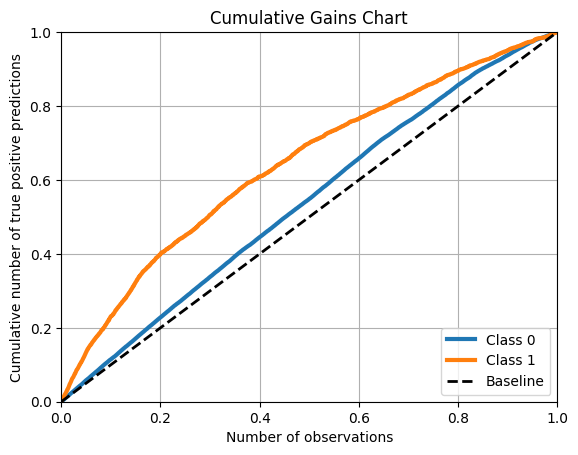

In [82]:
print(classification_report(Y_true_knn, Y_pred_predictions_knn))
plot_cumulative_gains_both_classes(np.array(Y_true_knn), Y_pred_probs_np_knn)

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     11594
           1       0.70      0.26      0.38      3405

    accuracy                           0.81     14999
   macro avg       0.76      0.61      0.63     14999
weighted avg       0.79      0.81      0.77     14999



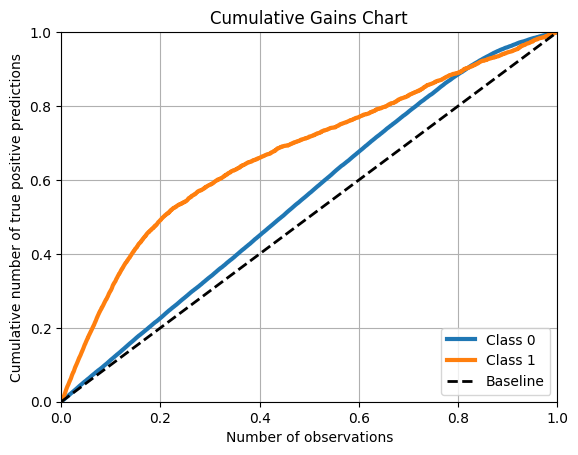

In [83]:
print(classification_report(Y_true_lda, Y_pred_predictions_lda))
plot_cumulative_gains_both_classes(np.array(Y_true_lda), Y_pred_probs_np_lda)

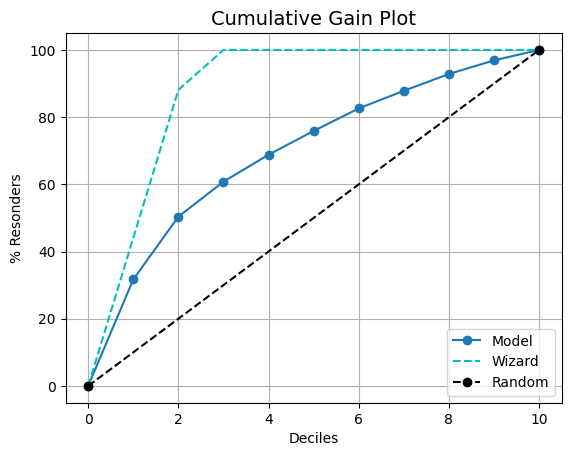

In [84]:
data_y_mlpc = np.array([elem[0] for elem in Y_true_mlpc])
kds.metrics.plot_cumulative_gain(data_y_mlpc, Y_pred_probs_np_mlpc[:, 1])

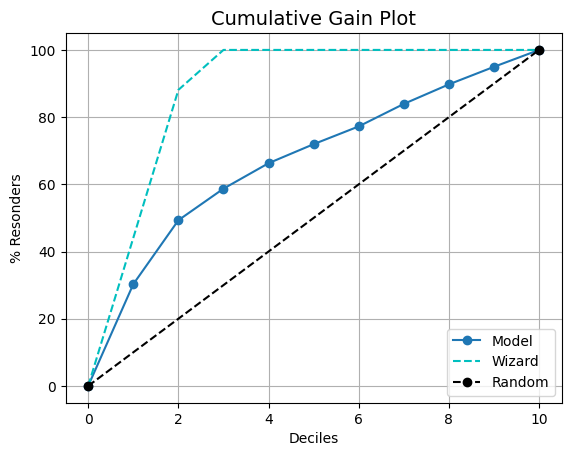

In [85]:
data_y_logreg = np.array([elem[0] for elem in Y_true_logreg])
kds.metrics.plot_cumulative_gain(data_y_logreg, Y_pred_probs_np_logreg[:, 1])

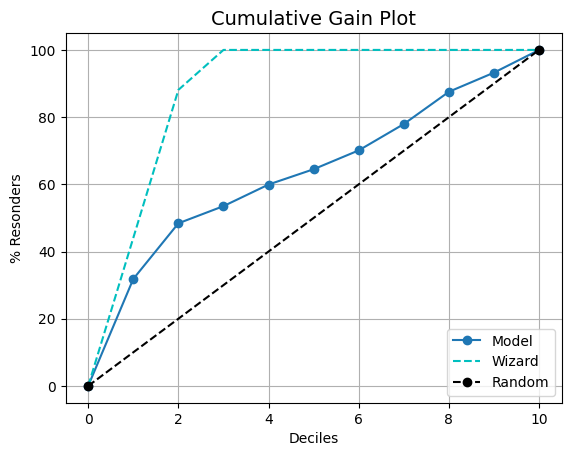

In [86]:
data_y_dect = np.array([elem[0] for elem in Y_true_dect])
kds.metrics.plot_cumulative_gain(data_y_dect, Y_pred_probs_np_dect[:, 1])

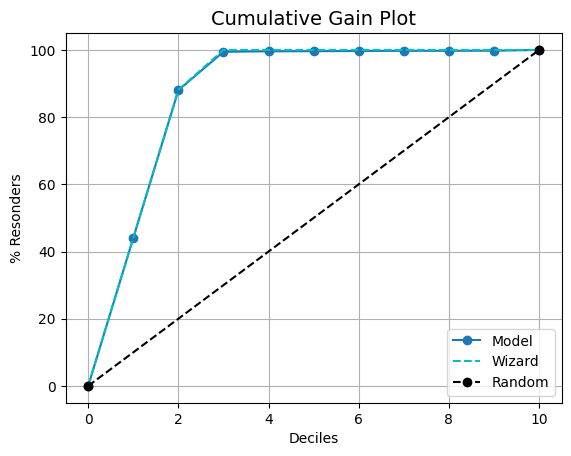

In [87]:
data_y_nb = np.array([elem[0] for elem in Y_true_nb])
kds.metrics.plot_cumulative_gain(data_y_nb, Y_pred_probs_np_nb[:, 1])

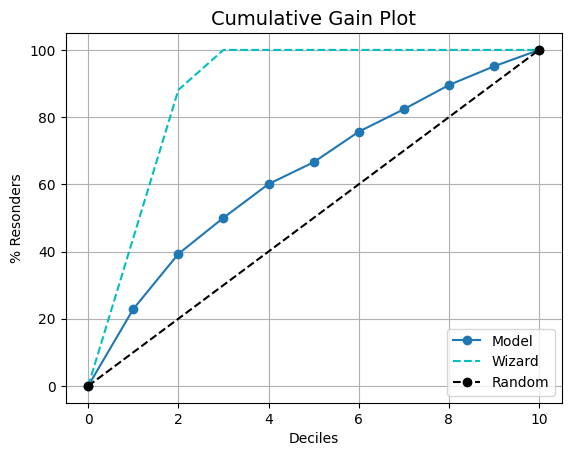

In [88]:
data_y_knn = np.array([elem[0] for elem in Y_true_knn])
kds.metrics.plot_cumulative_gain(data_y_knn, Y_pred_probs_np_knn[:, 1])

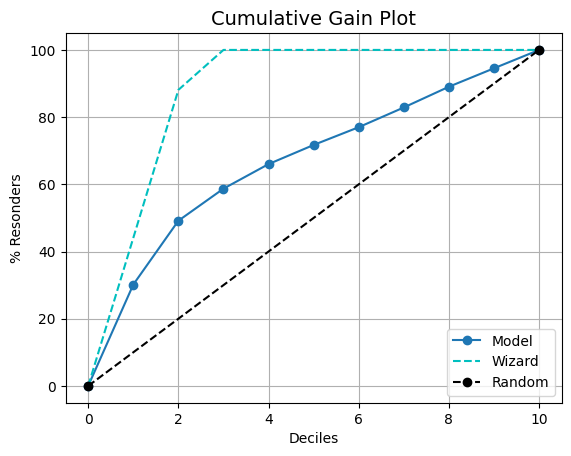

In [89]:
data_y_lda = np.array(Y_true_lda)
kds.metrics.plot_cumulative_gain(data_y_lda, Y_pred_probs_np_lda[:, 1])

In [90]:
def area_between_curves(curve_1, curve_2):
  """
  Function needed to compute the are between two curves expressed
  as array of floats of the same shape. These arrays contain just the
  y value of each point of the curve.

  Params:
    curve_1: array of floats of which we want to compute the area
             underneath it and subtract from it the area under curve_2
    curve_2: array of floats with the same shape of curve_1, of which
             we want to compute the area underneath it and subtract it
             to the area under curve_2
  Returns:
    difference_between_areas: difference between the
            computed areas below curve_1 and curve_2
  """
  acc_1 = (curve_1[0] / 2)
  acc_2 = (curve_2[0] / 2)
  difference_between_areas = 0
  for i in range(0, len(curve_1) - 1):
    acc_1 += (curve_1[i] + curve_1[i + 1]) / 2
    acc_2 += (curve_2[i] + curve_2[i + 1]) / 2
  difference_between_areas = (acc_1 - acc_2)
  return difference_between_areas

In [91]:
def compute_area_ratio_kds(data_y, Y_pred_probs_np):
  table = kds.metrics.decile_table(data_y, Y_pred_probs_np[:, 1], labels = False) 
  cum_resp_pct = table["cum_resp_pct"]
  cum_resp_pct_rndm = np.arange(10, 110, len(cum_resp_pct))
  cum_resp_pct_wiz = table["cum_resp_pct_wiz"]
  class_rnd_area = area_between_curves(cum_resp_pct, cum_resp_pct_rndm)
  wiz_rnd_area = area_between_curves(cum_resp_pct_wiz, cum_resp_pct_rndm)
  area_ratio =  class_rnd_area / wiz_rnd_area
  return area_ratio

In [92]:
area_ratio_mlpc = compute_area_ratio_kds(data_y_mlpc, Y_pred_probs_np_mlpc)
area_ratio_logreg = compute_area_ratio_kds(data_y_logreg, Y_pred_probs_np_logreg)
area_ratio_dect = compute_area_ratio_kds(data_y_dect, Y_pred_probs_np_dect)
area_ratio_nb = compute_area_ratio_kds(data_y_nb, Y_pred_probs_np_nb)
area_ratio_knn = compute_area_ratio_kds(data_y_knn, Y_pred_probs_np_knn)
area_ratio_lda = compute_area_ratio_kds(data_y_lda, Y_pred_probs_np_lda)

In [93]:
print("Area ratio for Multilayer Perceptron: " + str(area_ratio_mlpc))
print("Area ratio for Logistic Regression: " + str(area_ratio_logreg))
print("Area ratio for Decision Tree: " + str(area_ratio_dect))
print("Area ratio for Naive Bayes: " + str(area_ratio_nb))
print("Area ratio for K-Nearest Neighbors: " + str(area_ratio_knn))
print("Area ratio for Linear Discriminant Analysis: " + str(area_ratio_lda))

Area ratio for Multilayer Perceptron: 0.5173082408107619
Area ratio for Logistic Regression: 0.4512179485502108
Area ratio for Decision Tree: 0.3585392467533147
Area ratio for Naive Bayes: 0.9933928024722695
Area ratio for K-Nearest Neighbors: 0.34424414968638717
Area ratio for Linear Discriminant Analysis: 0.44284447049526526


In [94]:
def paper_like_cumulative_gain(true_y, probs_y):
  """
  Function needed to compute the curves (as arrays of floats)
  necessary to plot the cumulative gain chart in the same fashion of 
  the reference paper. In particular we want x_num_samples as the values
  for the x axis and the other three return values as the wizard, classifier
  and baseline curves.

  Params:
    true_y: true labels needed to compute the curves.
    probs_y: probabilities of having 1 as label, computed for each example
             by a classifier.
  Returns:
    classifier_curve: array containing the y values of the classifier curve,
                      it contains the cumulative values of the true labels
                      associated to the sorted array of predictions.
    cum_baseline: array containing the cumulative sum of the value 
                  (#positive_examples / #examples), this represents
                  the baseline classifier.
    best_curve: array containing the cumulative sum of the sorted true labels,
                it represents the best possible classifier.
    x_num_samples: values of the x axis, in particular it ranges from 0 to
                   (num_examples - 1)
  """
  num_examples = true_y.shape[0]
  x_num_samples = np.array([i for i in range(0, num_examples)])
  num_positives = sum(true_y)
  best_curve = np.cumsum(np.sort(true_y)[::-1])
  random_classifier_val = num_positives / num_examples
  baseline = np.array([random_classifier_val for i in range(0, num_examples)])
  cum_baseline = np.cumsum(baseline)
  sorted_idxs = np.argsort(probs_y)[::-1]
  classifier_curve = np.cumsum(np.array([true_y[i] for i in sorted_idxs]))
  return classifier_curve, cum_baseline, best_curve, x_num_samples

def plot_paper_like_gains(classifier_curve, cum_baseline, best_curve, x_num_samples):
  plt.plot(x_num_samples, best_curve, color = "blue")
  plt.plot(x_num_samples, cum_baseline, color = "green")
  plt.plot(x_num_samples, classifier_curve, color = "red")
  plt.show()

def plot_paper_like_gains_and_ratios(data_y, Y_pred_probs_np):
  classifier_curve, cum_baseline, best_curve, x_num_samples = paper_like_cumulative_gain(data_y, Y_pred_probs_np[:, 1])
  class_baseline_area = area_between_curves(classifier_curve, cum_baseline)
  baseline_best_area = area_between_curves(best_curve, cum_baseline)
  area_ratio =  class_baseline_area / baseline_best_area
  plot_paper_like_gains(classifier_curve, cum_baseline, best_curve, x_num_samples)
  print(area_ratio)

Paper-like cumulative gain plot and area ratio for Multi-layer perceptron:


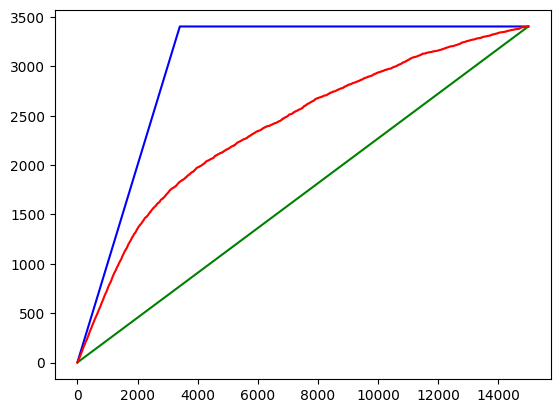

0.5189532689068296


In [95]:
print("Paper-like cumulative gain plot and area ratio for Multi-layer perceptron:")
plot_paper_like_gains_and_ratios(data_y_mlpc, Y_pred_probs_np_mlpc)

Paper-like cumulative gain plot and area ratio for Logistic Regression:


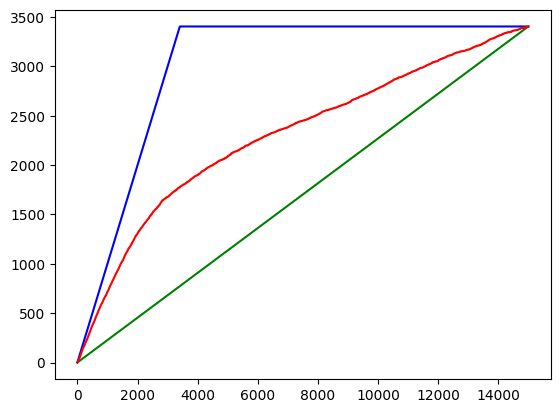

0.4538154704050413


In [96]:
print("Paper-like cumulative gain plot and area ratio for Logistic Regression:")
plot_paper_like_gains_and_ratios(data_y_logreg, Y_pred_probs_np_logreg)

Paper-like cumulative gain plot and area ratio for Decision Tree:


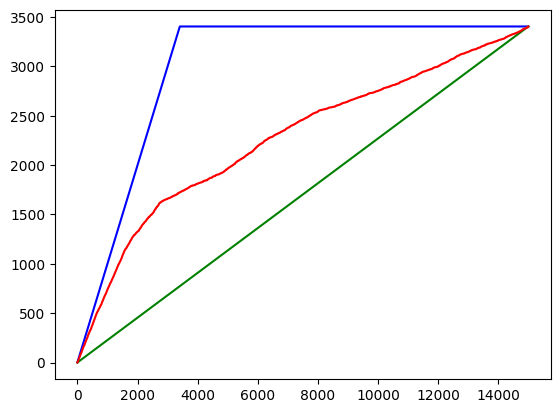

0.4316666400692307


In [97]:
print("Paper-like cumulative gain plot and area ratio for Decision Tree:")
plot_paper_like_gains_and_ratios(data_y_dect, Y_pred_probs_np_dect)

Paper-like cumulative gain plot and area ratio for Naive Bayes:


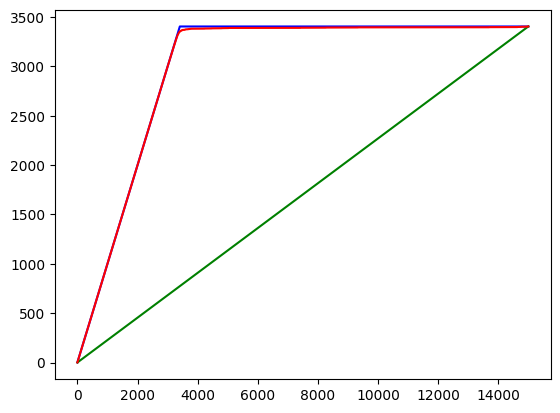

0.9927579129110523


In [98]:
print("Paper-like cumulative gain plot and area ratio for Naive Bayes:")
plot_paper_like_gains_and_ratios(data_y_nb, Y_pred_probs_np_nb)

Paper-like cumulative gain plot and area ratio for K-Nearest Neighbor:


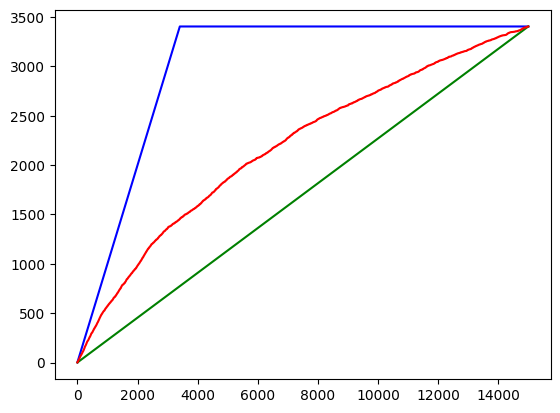

0.36293003850028266


In [99]:
print("Paper-like cumulative gain plot and area ratio for K-Nearest Neighbor:")
plot_paper_like_gains_and_ratios(data_y_knn, Y_pred_probs_np_knn)

Paper-like cumulative gain plot and area ratio for Linear Discriminant Analysis:


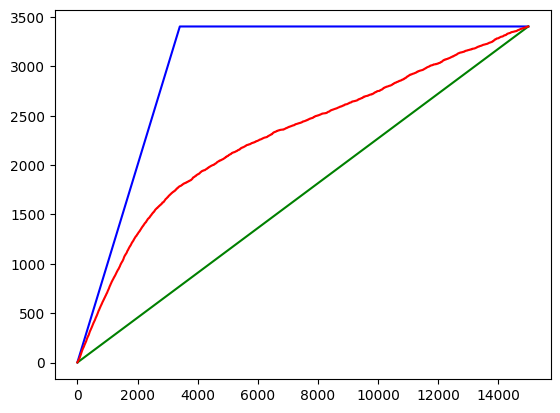

0.44588291528576646


In [100]:
print("Paper-like cumulative gain plot and area ratio for Linear Discriminant Analysis:")
plot_paper_like_gains_and_ratios(data_y_lda, Y_pred_probs_np_lda)

In [101]:
def sorting_smoothing_method(y_true, y_probs, n_smooth):
  """
  Function needed to estimate the real probability of default as 
  the mean of the n_smooth neighboring labels of a label y_i, where
  a neighbor of y_i (i.e. y_i+1) is the label associated to the 
  i+1 probability value in the sorted array of probabilities computed
  by the classifier. In more simple terms: real probabilities are the mean
  of the (2*n_smooth + 1) true labels ordered according to the sorted y_probs.

  Params: 
    y_true: array of true labels of which we want to estimate 
            the real probabilities
    y_probs: array of probabilities computed by a classifier
    n_smooth: number of smoothing neighbors to consider in order to 
              estimate real probabilities
  Returns: 
    p_vec: estimated real probability values for each true label in y_true
  """
  sort_idx = np.argsort(y_probs[:, 1])
  n_total = y_true.shape[0]
  p_vec = np.zeros(n_total)
  for i in range(0, n_total):
    acc = y_true[sort_idx[i]]
    n_acc = 0
    for n in range(0, n_smooth):
      if i + n < n_total:
        acc += y_true[sort_idx[i + n]]
        n_acc += 1
      if i - n >= 0:
        acc += y_true[sort_idx[i - n]]
        n_acc += 1
    p_vec[i] = acc / n_acc
  return p_vec

def plot_sorting_smoothing_chart(data_y, Y_pred_probs_np):
  p_vec = sorting_smoothing_method(data_y, Y_pred_probs_np, 50)
  ord_probs = np.sort(Y_pred_probs_np[:, 1])

  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ord_probs, p_vec)

  plt.plot(ord_probs, p_vec, 'o', color='blue')
  plt.plot(ord_probs, slope*ord_probs + intercept, color = "red")
  plt.show()

  print("m value: " + str(slope))
  print("q value: " + str(intercept))
  print("r value: " + str(r_value))
  print("r squared: " + str(np.power(r_value, 2)))

Sorting smoothing chart for Multi-Layer Perceptron: 


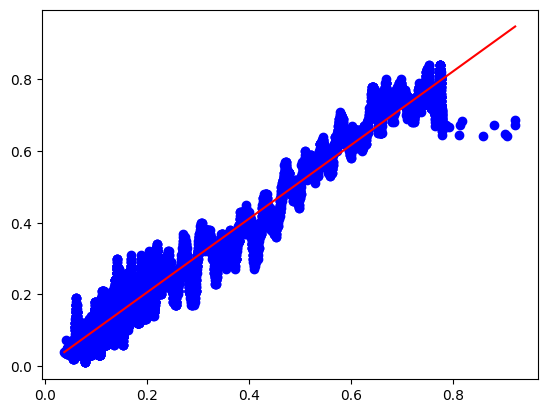

m value: 1.0275600484801528
q value: 0.0005160790469490861
r value: 0.9782490040235822
r squared: 0.9569711138731305


In [102]:
print("Sorting smoothing chart for Multi-Layer Perceptron: ")
plot_sorting_smoothing_chart(data_y_mlpc, Y_pred_probs_np_mlpc)

Sorting smoothing chart for Logistic Regression: 


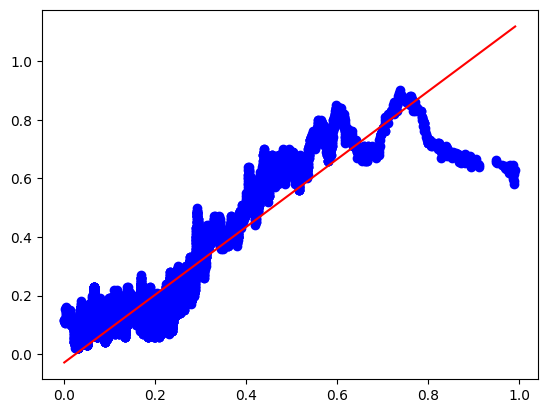

m value: 1.156548748597887
q value: -0.028554989160422428
r value: 0.9084384989339218
r squared: 0.8252605063453171


In [103]:
print("Sorting smoothing chart for Logistic Regression: ")
plot_sorting_smoothing_chart(data_y_logreg, Y_pred_probs_np_logreg)

Sorting smoothing chart for Decision Tree: 


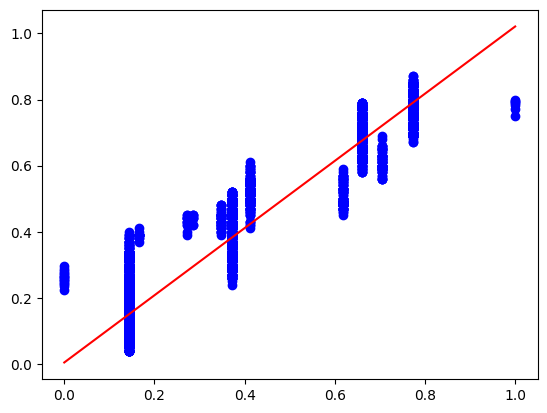

m value: 1.0167872160723483
q value: 0.004195734585680816
r value: 0.957824132025633
r squared: 0.9174270678906572


In [104]:
print("Sorting smoothing chart for Decision Tree: ")
plot_sorting_smoothing_chart(data_y_dect, Y_pred_probs_np_dect)

Sorting smoothing chart for Naive Bayes: 


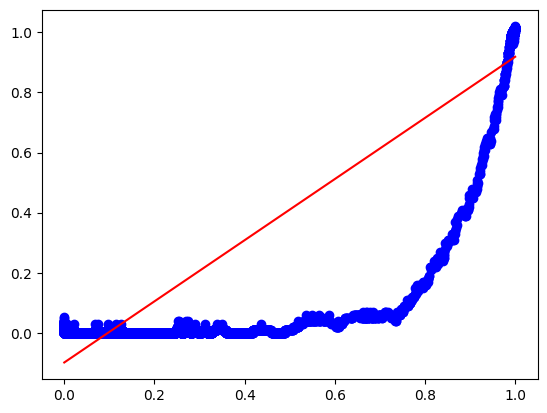

m value: 1.0173604236006553
q value: -0.09854258762476026
r value: 0.9478593876826207
r squared: 0.8984374188180726


In [105]:
print("Sorting smoothing chart for Naive Bayes: ")
plot_sorting_smoothing_chart(data_y_nb, Y_pred_probs_np_nb)

Sorting smoothing chart for K-Nearest Neighbor: 


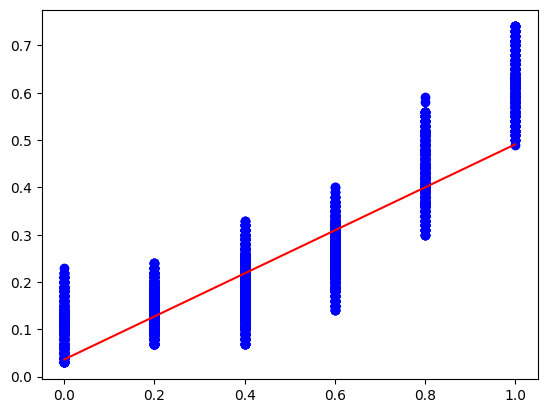

m value: 0.4545166878254927
q value: 0.03641931707300225
r value: 0.8759491025731037
r squared: 0.7672868302986257


In [106]:
print("Sorting smoothing chart for K-Nearest Neighbor: ")
plot_sorting_smoothing_chart(data_y_knn, Y_pred_probs_np_knn)

Sorting smoothing chart for Linear Discriminant Analysis: 


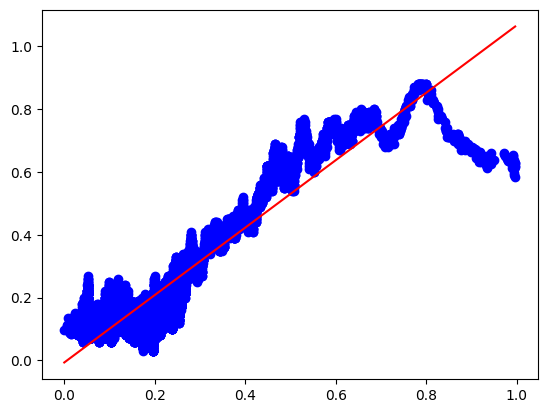

m value: 1.0740236539440096
q value: -0.00673955013243871
r value: 0.9217679914675541
r squared: 0.8496562300941288


In [107]:
print("Sorting smoothing chart for Linear Discriminant Analysis: ")
plot_sorting_smoothing_chart(data_y_lda, Y_pred_probs_np_lda)

In [108]:
spark.stop()